# Credit Scoring Competition

## 1. Import libs

In [122]:
import pandas as pd
import pandas_profiling
import numpy as np
import xgboost
import lightgbm as lgb
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import scikit_posthocs as sp
from scipy.stats.mstats import winsorize

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import seaborn as sns 

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot

from catboost import CatBoostClassifier, Pool, cv
import missingno as msno

import folium

pyo.init_notebook_mode(connected=True)
cf.go_offline()

#for dirname, _, filenames in os.walk('/kaggle'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [123]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

CURRENT_DATE = pd.to_datetime('15/09/2020')

## 2. Data preparing

In [124]:
DATA_DIR = 'C:/Users/Игорь/dst-4/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

pd.set_option('display.max_columns', None)

In [125]:
print ("формат обучающей выборки:", df_train.shape)
print ("формат тестовой выборки:", df_test.shape)
print ("формат submission:", sample_submission.shape)

формат обучающей выборки: (73799, 19)
формат тестовой выборки: (36349, 18)
формат submission: (24354, 2)


In [126]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [127]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [128]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [129]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

<AxesSubplot:>

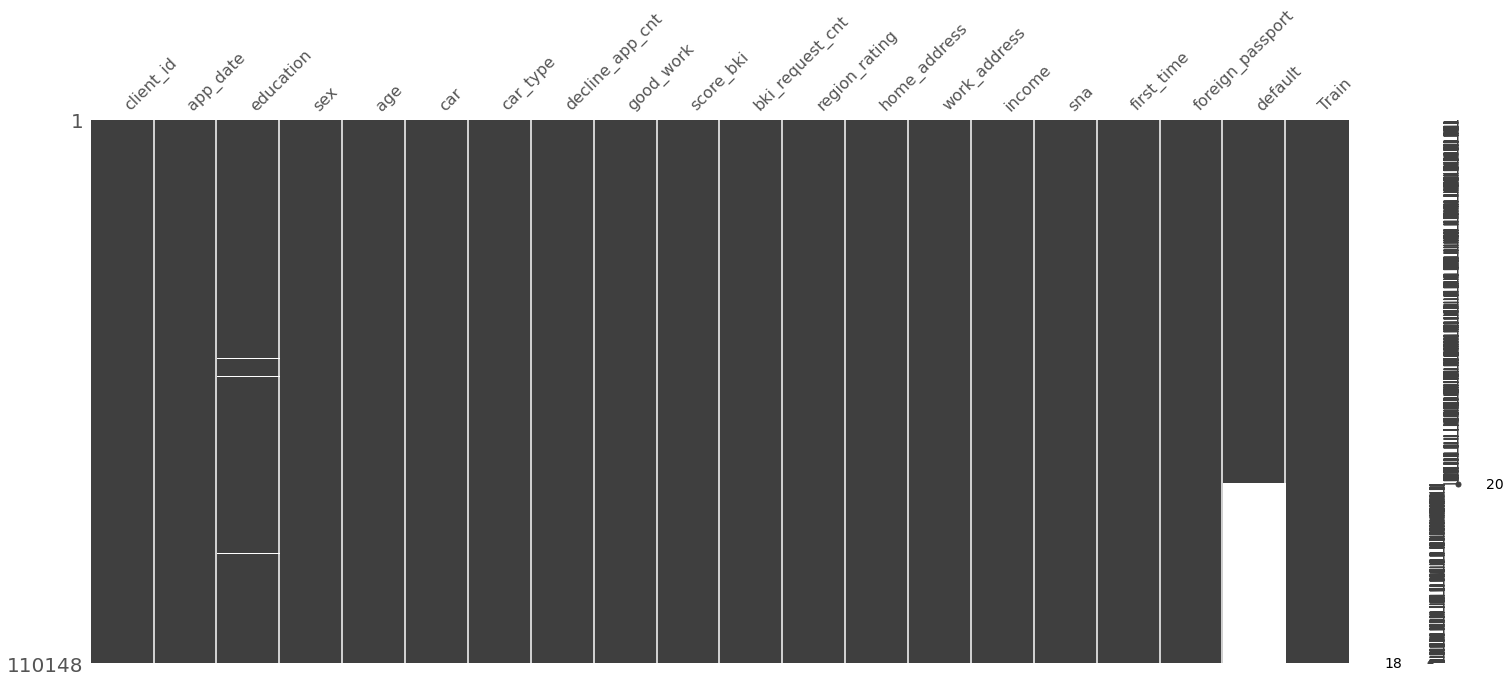

In [131]:
#Рассмотрим количество пропусков
msno.matrix(df) 

Подробнее по признакам:
* **client_id** - идентификатор клиента
* **education** - уровень образования(SCH (школа), UGR (кандидат в бакалавры), GRD (бакалавр), PGR (магистр), ACD (академик))
* **sex** - пол заемщика
* **age** - возраст заемщика
* **car** - флаг наличия автомобиля
* **car_type** - флаг автомобиля иномарки
* **decline_app_cnt** - количество отказанных прошлых заявок 
* **good_work - флаг** наличия “хорошей” работы
* **bki_request_cnt** - количество запросов в БКИ
* **home_address** - категоризатор домашнего адреса
* **work_address** - категоризатор рабочего адреса
* **income** - доход заемщика
* **foreign_passport** - наличие загранпаспорта
* **sna** - связь заемщика с клиентами банка
* **first_time** - давность наличия информации о заемщике
* **score_bki** - скоринговый балл по данным из БКИ
* **region_rating** - рейтинг региона
* **app_date** - дата подачи заявки
* **default** - флаг дефолта по кредиту

In [132]:
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (5, без default)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (6)
cat_cols = ['region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'education']
# числовые переменные, исключили из списка (5, без client_id)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

## 3. Analysis of columns

### 3.1 Numeric 

In [133]:
# составим функции обработки столбцов
def process_numerical(column):
    '''Функция обработки числовых столбцов'''
    
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    median = df[column].median()
    IQR    = perc75 - perc25
    range_min = df[column].min()
    range_max = df[column].max()   
    range_hist = (range_min, range_max)
    nan_count = df[column].isna().sum()
    emissions = df[column].loc[(df[column] < perc25 - 1.5*IQR) | (df[column] > perc75 + 1.5*IQR)]
    
    df[column].describe();
    print('Количество пропусков в столбце: '.format(nan_count),
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        'IQR: {}, '.format(IQR))
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(emissions))
     
    df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                    .hist(bins = 15, range = range_hist, label = 'IQR')
    
    emissions.hist(bins = 15, range = range_hist, color = 'blue', label = 'Выбросы')
     
    plt.legend()

### **Age**

Количество пропусков в столбце:  25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0, 
Границы выбросов: [3.0, 75.0]. Количество выбросов:  0


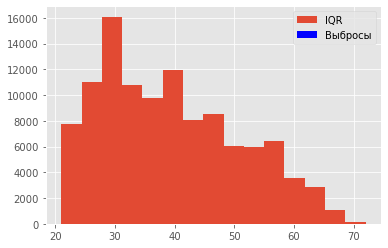

In [134]:
process_numerical('age')

In [135]:
df['age'] = np.log(df['age'] + 1)

**Вывод** : Распределение логнормальное, выбросов нет. Взяли логарифм от признака.

### **Decline_app_cnt**

Количество пропусков в столбце:  25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0, 
Границы выбросов: [0.0, 0.0]. Количество выбросов:  18677


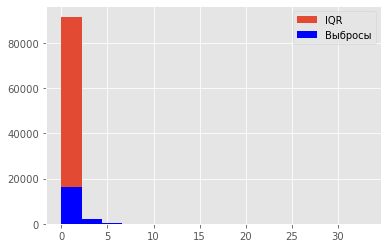

In [136]:
process_numerical('decline_app_cnt')

E:\Pyton\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='decline_app_cnt'>

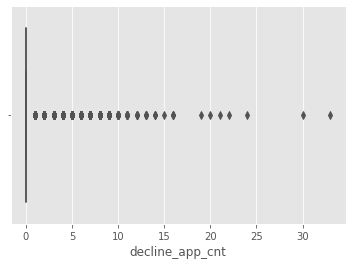

In [137]:
# Столбец содержит выбросы
sns.boxplot(df['decline_app_cnt'])

**Вывод** : Распределение логнормальное, выбросов очень много, взяли логарифм от признака.

### **Bki_request_cnt**

Количество пропусков в столбце:  25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0, 
Границы выбросов: [-4.5, 7.5]. Количество выбросов:  2636


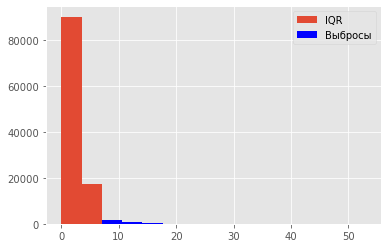

In [138]:
process_numerical('bki_request_cnt')

E:\Pyton\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



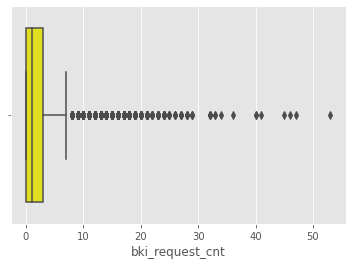

In [139]:
# Столбец содержит выбросы
sns.boxplot(df.bki_request_cnt, color='yellow');

In [140]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

**Вывод** : Распределение логнормальное, выбросов меньше, взяли логарифм от признака.

### **Income**

Количество пропусков в столбце:  25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0, 
Границы выбросов: [-22000.0, 90000.0]. Количество выбросов:  7000


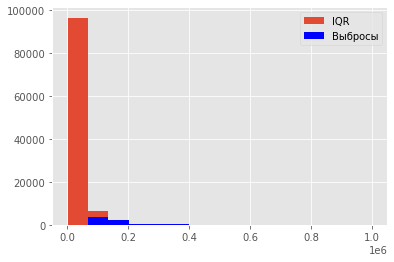

In [141]:
process_numerical('income')

E:\Pyton\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



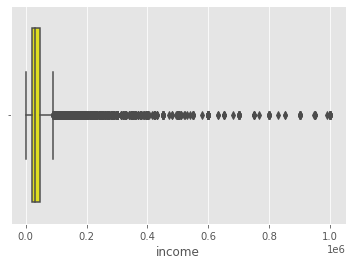

In [142]:
sns.boxplot(df.income, color='yellow');

In [143]:
df['income'] = np.log(df['income'] + 1)

**Вывод** : Распределение логнормальное, выбросов очень много, взяли логарифм от признака.

### **Score_bki**

Количество пропусков в столбце:  25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004, 
Границы выбросов: [-3.299251946250001, -0.5290698762499992]. Количество выбросов:  518


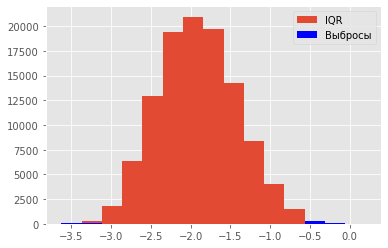

In [144]:
process_numerical('score_bki')

E:\Pyton\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



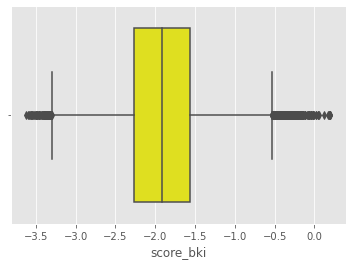

In [145]:
sns.boxplot(df.score_bki, color='yellow');

In [146]:
df['score_bki'] = abs(df['score_bki'])
df['score_bki'] = np.log(df['score_bki'] + 1)

**Вывод** : Распределение логнормальное, выбросов меньше, взяли логарифм от признака.

### 3.2 Categorial 

### **Sna**

In [150]:
df[['sna']].iplot(kind='histogram', title='Связь с клиентами банка по заемщикам')

In [74]:
### **Decline_app_cnt**

In [75]:
### **Decline_app_cnt**

In [76]:
### **Decline_app_cnt**

In [77]:
### **Decline_app_cnt**

## 4. Correlation analysis

<AxesSubplot:>

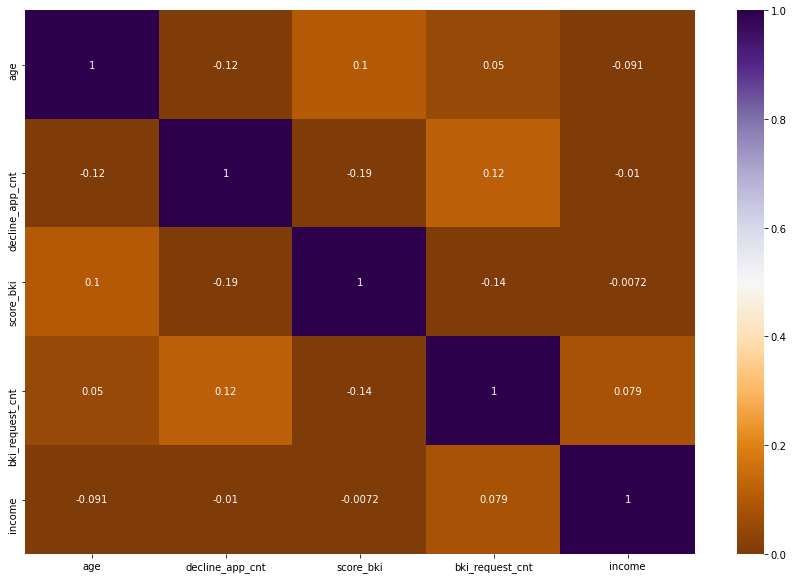

In [78]:
corr = df[num_cols].corr(method='pearson')
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap="PuOr", annot=True, vmin=0, vmax=1)

In [79]:
df[num_cols].corr()

,age,decline_app_cnt,score_bki,bki_request_cnt,income
age,1.000000,-0.118243,0.104708,0.050241,-0.090734
decline_app_cnt,-0.118243,1.000000,-0.191858,0.118954,-0.010118
score_bki,0.104708,-0.191858,1.000000,-0.140663,-0.007246
bki_request_cnt,0.050241,0.118954,-0.140663,1.000000,0.078649
income,-0.090734,-0.010118,-0.007246,0.078649,1.000000


**Вывод** : Взаимосвязь пар числовых признаков по Пирсону слабая. Максимальный коэффициент 0.205623. Мультиколлинеарность отсутствует, оставляем все числовые признаки для модели

## 5. Significant variables

In [148]:
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
#сортировка по убыванию
imp_num.sort_values(inplace = True)
#barh - для переворачивания гистограммы
imp_num.plot(kind = 'barh')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').